In [5]:
# from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from sympy import Heaviside, sin, pi, exp
import warnings

warnings.filterwarnings("ignore")

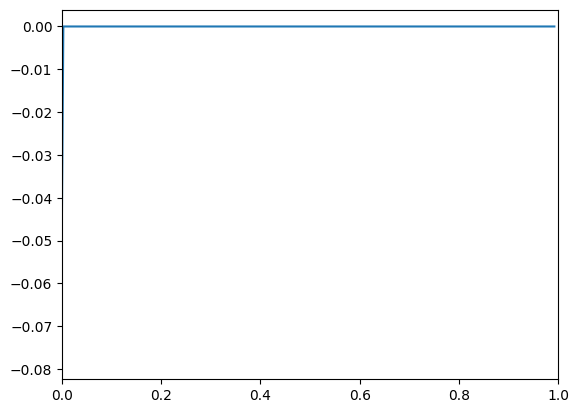

In [6]:
l = 1 # length    
l1 = 0.5e-1 # heaviside parameter
l2 = 0.3 # heaviside parameter
N = 200 # number of steps
v = 1 # velocity
Cu = 0.5 # Courant number
dx = l / N
dt = Cu * dx / v
M = int(0.4 * N / Cu)
T = 5 * l / (25 * v) # sinusoid period

# Version of initial conditions
# 1 - sin, 2 - step, 3 - rectangle, 4 - TwinPeaks, 5 - constant
nInitial = 1

x = [(1/2) * dx + (i - 1) * dx for i in range(N)]
cinit = [] # array of initial conditions

if nInitial == 1:
    f0 = lambda y, t: Heaviside(-y + v * t) * sin(2 * np.pi * (y - v * t) / (T * v))
    M *= 2
elif nInitial == 2:
    f0 = lambda y, t: Heaviside(-y + v * t)
elif nInitial == 3:
    f0 = lambda y, t: Heaviside(y - v * t - l1) * Heaviside(-y + v * t + l2)
elif nInitial == 4:
    dg = 0.1 * l
    x1 = 2 * dg
    x2 = x1 + 2 * dg
    f0 = lambda y, t: exp(-(y - v * t - x1)**2 / dg**2) + exp(-(y - v * t - x2)**2 / dg**2)
elif nInitial == 5:
    f0 = lambda y, t: 1
for i in range(N):
    cinit.append(f0(x[i], 0))

plt.plot(x, cinit)
plt.xlim(0, 1)
plt.show()

In [7]:
nMethod = 0
tcurr = 0
t1 = 0

c1 = np.copy(cinit)
c2 = np.copy(cinit)

for j in range(M):
    t0 = t1
    t1 = tcurr
    tcurr += dt
    
    canalytics = [f0(x[i], tcurr) for i in range(0, N)]

    c0 = np.copy(c1)
    c1 = np.copy(c2)
    c2 = np.zeros_like(c2)
    # Left boundary condition
    c0[0] = f0(0, t0)
    c1[0] = f0(0, t1)
    c2[0] = f0(0, tcurr)
    

    cU = np.zeros(N)
    cCross = np.zeros(N)
    FR = np.zeros(N)
    FL = np.zeros(N)
    FRcross = np.zeros(N)
    for i in range(1, N-1):
        FR[i]= c1[i]
        FL[i] = c1[i-1]

        FRcross[i-1] = c1[i] + c1[i-1]
        
        cU[i] = c1[i] - v*dt/dx * (FR[i]-FL[i])

        if j == 0:
            cCross[i] = cU[i]
        else:
            cCross[i] = c0[i] + v*dt/dx * (c1[i-1] - c1[i+1])      

    # # limiter
    # for i in range(1, N-2):
    #     r = (cCross[i]-cCross[i-1]) / (cCross[i+1]-cCross[i] + 1E-10)

    #     # c2[i] = cU[i] + superbee(r) * (cCross[i] - cU[i])
    #     # c2[i] = cU[i] + ospre(r) * (cCross[i] - cU[i])
        
    #     if r < 0:
    #         c2[i] = cU[i]
    #     else:
    #         c2[i] = cCross[i]
    
    # dca = np.zeros(N)
    # for i in range(1, N-2):
    #     dca[i] = cCross[i+1]-cCross[i]

    FC = np.zeros(N)
    for i in range(1, N - 1):
        if abs(cCross[i+1] - cCross[i]) < 1E-10:
            FC[i] = 0
        else:
            r = (cCross[i]-cCross[i-1]) / (cCross[i+1]-cCross[i] + 1E-10)
             # phi = max(0, min(2 * r, 1), min(r, 2))
            phi = 1.5*(r**2 + r)/(r**2 + r + 1)
            FC[i] = (v * dt / dx) * phi * (FRcross[i] - FR[i])

    for i in range(1, N - 1):
        # c2[i] = cU[i] - (FC[i] - FC[i - 1])
        # c2[i] = cU[i]
        # c2[i] = cCross[i] - (FC[i] - FC[i - 1])
        c2[i] = cCross[i]
        # if (abs(FC[i] - FC[i - 1]) > abs(c2[i]*10)):
        #     print(i, ' ', FC[i] - FC[i - 1], ' ', c2[i])

    # for i in range(2, N - 1):
    #     if i == N - 1:
    #         c0[i] = 0
    #     else:
    #         c0[i] = c2[i]

    # c2[N-1] = cU[N-1]
    c2[N-1] = c2[N-2]
    # print(c2[N-1], "\n")

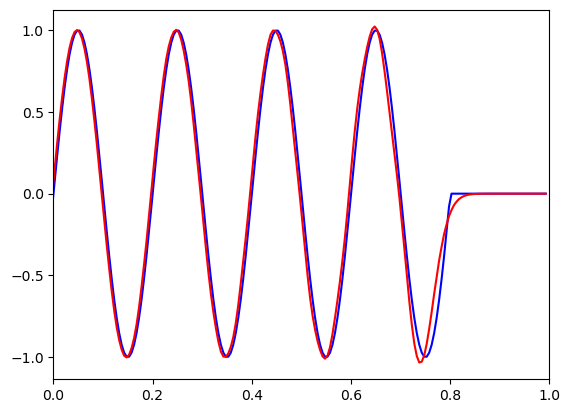

In [128]:
plt.plot(x, canalytics, c='b')
plt.plot(x, c2, c='r')
plt.xlim(0, 1)
plt.show()

In [94]:
cmaxmod = 0
L2 = 0

for i in range(N):
    cmaxmod = max(cmaxmod, abs(c2[i]-canalytics[i]))
    L2 += (c2[i]-canalytics[i])**2 * dx
L2 = L2**(1/2)
print(f'MaxMod = {cmaxmod}\nL2 = {L2}')

MaxMod = 0.0297295175459037
L2 = 0.00490692887873985


MaxMod = 0.270800816519629
L2 = 0.0947927867285528

In [117]:
def superbee(r):
    if 1/(r + 1E-05) < 1E-03:
        return 2
    else:
        return max(0, min(2*r, 1), min(r, 2))

def ospre(r):
    if 1/(r + 1E-05) < 1E-03:
        return 1.5
    else:
        return 1.5*(r**2 + r)/(r**2 + r + 1)